In [ ]:
# Привет! Работу я выполнял в ноутбуке на кагле, где кучу экспериментов опустил. Так легче читать и проверять. 
# Все основные опыты, из тех которые успел, я выполнял в ноутбуке где ДЗ(на Колабе). В этой работе я пару раз ссылаюсь на те 
# свои опыты(в частности объясняю просадку val_acc несбалансированностью классов). Я поэксперементировал и с аугментацией, и с 
# архитектурой(пробовал свою написать), с другими гиперпараметрами.
# Ноутбук с опытами: https://drive.google.com/file/d/1wPzeWSllGZXuB5qRnOMwhQv76Jp82FWD/view?usp=drive_link

In [9]:
import os

# Проверяем, что залили\подключили архив с датасетом
input_dir = '/kaggle/input/'  
files = os.listdir(input_dir)  
# print("Файлы во входном датасете:")
for file in files:
    print(file) 

journey-springfield-zip


In [10]:
# Вывод содержимого
dataset_path = '/kaggle/input/journey-springfield-zip/'
contents = os.listdir(dataset_path)
print("Содержимое датасета:")
for item in contents:
    print(f"• {item}")

Содержимое датасета:
• sample_submission.csv
• testset
• characters_illustration.png
• train


In [11]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [12]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [14]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [15]:
# Модифицированный SimpsonsDataset
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который параллельно подгружает их из папок,
    производит скалирование и превращение в тензоры PyTorch
    """
    def __init__(self, files, mode, label_encoder=None):
        super().__init__()
        # Список файлов для загрузки
        self.files = sorted(files)
        # Режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        # Единый LabelEncoder для всех датасетов
        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            if label_encoder is None:
                # Создаем новый энкодер только для train датасета
                self.label_encoder = LabelEncoder()
                self.label_encoder.fit(self.labels)

                # Сохраняем энкодер
                with open('label_encoder.pkl', 'wb') as le_dump_file:
                    pickle.dump(self.label_encoder, le_dump_file)
            else:
                # Используем переданный энкодер для val датасета
                self.label_encoder = label_encoder

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # Преобразование изображений в тензоры PyTorch и нормализация
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)

        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

    def get_label_encoder(self):
        """Метод для получения энкодера меток"""
        return self.label_encoder

In [16]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [17]:
# TRAIN_DIR = Path('./data/train/')
# TEST_DIR = Path('./data/testset')

TRAIN_DIR = Path('/kaggle/input/journey-springfield-zip/train/simpsons_dataset')
TEST_DIR = Path('/kaggle/input/journey-springfield-zip/testset')

In [18]:
# Проверяем, что правильно подключили каталоги(в них д.б. файлики)

input_dir = TRAIN_DIR  
files = os.listdir(input_dir)  
# print("Файлы во входном датасете:")
for file in files:
    print(file) 

rainier_wolfcastle
maggie_simpson
krusty_the_clown
waylon_smithers
professor_john_frink
fat_tony
ralph_wiggum
otto_mann
martin_prince
barney_gumble
ned_flanders
patty_bouvier
sideshow_mel
marge_simpson
abraham_grampa_simpson
selma_bouvier
mayor_quimby
disco_stu
lionel_hutz
troy_mcclure
agnes_skinner
groundskeeper_willie
kent_brockman
charles_montgomery_burns
carl_carlson
chief_wiggum
apu_nahasapeemapetilon
bart_simpson
edna_krabappel
gil
comic_book_guy
principal_skinner
cletus_spuckler
milhouse_van_houten
snake_jailbird
nelson_muntz
lisa_simpson
lenny_leonard
moe_szyslak
miss_hoover
homer_simpson
sideshow_bob


In [19]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [20]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]

train_files, val_files = train_test_split(train_val_files, test_size=0.25,stratify=train_val_labels)

# Перемешиваем (у нас всего 42 класса, которые кстати несбалансированы - это я отдельно выяснил)
# train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
#                                           stratify=train_val_labels, shuffle=True, random_state=42)


In [21]:
val_dataset = SimpsonsDataset(val_files, mode='val')
train_dataset = SimpsonsDataset(train_files, mode='train')

n_classes = len(np.unique(train_val_labels))

print(f"Число классов: {n_classes}")
print(f"Обучаем на {len(train_files)} картинках")
print(f"Валидируем по {len(val_files)} картинкам")
print(f"Тестируем по {len(test_files)} картинкам")

Число классов: 42
Обучаем на 15699 картинках
Валидируем по 5234 картинкам
Тестируем по 991 картинкам


In [22]:
def fit_epoch(model, train_loader, criterion, optimizer):
    """
    Функция обучает модель на одной эпохе, используя предоставленный dataloader.

    Эта функция проходит по всем данным в `train_loader`, выполняет шаг моделью (forward),
    вычисляет лосс, выполняет обратное распространение с помощью заданного
    оптимизатора и обновляет веса модели.
    В конце эпохи возвращаются средний лосс и
    точность на обучающем наборе данных.

    Параметры:
    ----------
    model : nn.Module
        Модель, которую необходимо обучить. Должна быть экземпляром класса
        PyTorch `nn.Module`.

    train_loader : DataLoader
        Загрузчик данных, который предоставляет батчи входных данных и
        соответствующих меток. Должен возвращать кортежи (inputs, labels).

    criterion : nn.Module
        Функция потерь, используемая для вычисления ошибки между
        предсказаниями модели и истинными метками.

    optimizer : torch.optim.Optimizer
        Оптимизатор, используемый для обновления весов модели на основе
        градиентов, вычисленных в процессе обучения.

    Функция возвращает:
    ----------
    tuple
        Кортеж, содержащий средний лосс (train_loss) и точность (train_acc)
        на обучающем наборе данных за текущую эпоху.
    """

    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [23]:
# def eval_epoch(model, val_loader, criterion):
#     """
#     Функция оценивает работу модели на валидационном наборе данных за одну эпоху.

#     Эта функция проходит по всем данным в `val_loader`, выполняет прямое
#     распространение, вычисляет лосс и точность модели. В конце эпохи
#     возвращаются средний лосс и точность на валидационном наборе данных.

#     Параметры:
#     ----------
#     model : nn.Module
#         Модель, которую необходимо оценить. Должна быть экземпляром класса
#         PyTorch `nn.Module`.

#     val_loader : DataLoader
#         Загрузчик данных, который предоставляет батчи входных данных и
#         соответствующих меток для валидации. Должен возвращать кортежи
#         (inputs, labels).

#     criterion : nn.Module
#         Функция потерь, используемая для вычисления ошибки между
#         предсказаниями модели и истинными метками.

#     Функция возвращает:
#     ----------
#     tuple
#         Кортеж, содержащий среднюю потерю (val_loss) и точность (val_acc)
#         на валидационном наборе данных за текущую эпоху.
#     """
#     model.eval()
#     running_loss = 0.0
#     running_corrects = 0
#     processed_size = 0

#     for inputs, labels in val_loader:
#         inputs = inputs.to(DEVICE)
#         labels = labels.to(DEVICE)

#         with torch.set_grad_enabled(False):
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             preds = torch.argmax(outputs, 1)

#         running_loss += loss.item() * inputs.size(0)
#         running_corrects += torch.sum(preds == labels.data)
#         processed_size += inputs.size(0)
#     val_loss = running_loss / processed_size
#     val_acc = running_corrects.double() / processed_size
#     return val_loss, val_acc


# Чуть с модификацией
def eval_epoch(model, val_loader, criterion):
    model.eval()  # Важно для Dropout/BatchNorm!
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    with torch.no_grad():  # Более современный аналог set_grad_enabled(False)
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels)
            processed_size += inputs.size(0)

    if processed_size == 0:
        raise ValueError("Validation loader is empty!")
        
    val_loss = running_loss / processed_size
    val_acc = running_corrects.float() / processed_size  # Оптимальный тип
    
    return val_loss, val_acc

In [24]:
# def train(train_files, val_files, model, epochs, batch_size):
#     """
#     Функция обучает модель на обучающем наборе данных и оценивает ее на валидационном наборе данных.

#     Эта функция создает загрузчики данных для обучающего и валидационного наборов,
#     а затем выполняет обучение модели в течение заданного количества эпох.
#     В конце каждой эпохи выводятся значения потерь и точности для обучающего и
#     валидационного наборов. История обучения сохраняется и возвращается.

#     Параметры:
#     ----------
#     train_files : list
#         Список файлов или путей к файлам, содержащим обучающие данные.

#     val_files : list
#         Список файлов или путей к файлам, содержащим валидационные данные.

#     model : nn.Module
#         Модель, которую необходимо обучить. Должна быть экземпляром класса
#         PyTorch `nn.Module`.

#     epochs : int
#         Количество эпох для обучения модели.

#     batch_size : int
#         Размер батча, используемый для загрузки данных.

#     Возвращает:
#     ----------
#     list
#         Список, содержащий кортежи (train_loss, train_acc, val_loss, val_acc)
#         для каждой эпохи, где:
#         - train_loss: средняя потеря на обучающем наборе.
#         - train_acc: точность на обучающем наборе.
#         - val_loss: средняя потеря на валидационном наборе.
#         - val_acc: точность на валидационном наборе.
#     """
#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#     val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

#     history = []
#     log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
#     val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

#     best_val_acc = 0.0  # Для отслеживания лучшей точности

#     with tqdm(desc="epoch", total=epochs) as pbar_outer:
#         opt = torch.optim.Adam(model.parameters())
#         criterion = nn.CrossEntropyLoss()

#         for epoch in range(epochs):
#             train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
#             print("loss", train_loss)

#             val_loss, val_acc = eval_epoch(model, val_loader, criterion)
#             history.append((train_loss, train_acc, val_loss, val_acc))

#             # Сохраняем модель, если val_acc улучшился
#             if val_acc > best_val_acc:
#                 best_val_acc = val_acc
#                 torch.save(model.state_dict(), 'best_model.pth')  # Сохранение весов

#             pbar_outer.update(1)
#             tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
#                                            v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

#     return history


# Слегка модифицируем
def train(model, train_loader, val_loader, epochs, optimizer, criterion, 
          scheduler=None, save_best=True):
    history = []
    best_val_acc = 0.0
    
    with tqdm(desc="epoch", total=epochs) as pbar:
        for epoch in range(epochs):
            # Обучение
            model.train()
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, optimizer)
            
            # Валидация
            model.eval()
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            
            # Обновление планировщика
            if scheduler:
                scheduler.step()
            
            # Сохранение истории
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            # Сохранение лучшей модели
            if save_best and val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(model.state_dict(), 'best_model.pth')
            
            # Логирование
            pbar.update(1)
            pbar.set_postfix_str(f"train_loss: {train_loss:.4f}, val_acc: {val_acc:.4f}")
    
    return history

In [25]:
# Чуть модифицирована
def predict(model, test_loader):
    """
    Функция выполняет предсказание классов для тестового набора данных с использованием обученной модели.

    Эта функция принимает модель и загрузчик тестовых данных, применяет модель к
    изображениям и возвращает вероятности предсказанных классов.

    Параметры:
    ----------
    model : nn.Module
        Обученная модель, которая будет использоваться для предсказания.
        Должна быть экземпляром класса PyTorch `nn.Module`.

    test_loader : DataLoader
        Загрузчик данных, который предоставляет батчи входных данных для тестирования.
        Должен возвращать тензоры входных данных.

    Возвращает:
    ----------
    numpy.ndarray
        Массив вероятностей предсказанных классов для каждого примера в тестовом наборе.
        Размерность массива будет (N, C), где N - количество примеров, а C - количество классов.
    """

    with torch.inference_mode():  # Более эффективно, чем no_grad()
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            # model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [26]:
from torchvision import models, transforms
from torchvision.models import resnet50

In [27]:
# Пробуем ResNet50
model = models.resnet50(weights="IMAGENET1K_V2")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 225MB/s]


In [28]:
# Выводим структуру
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [29]:
# Контроль выходного слоя(нам нужны только 42 класса, а не 1000)
model.fc = nn.Linear(in_features=model.fc.in_features, out_features=42, bias=True)
print(model.fc)

Linear(in_features=2048, out_features=42, bias=True)


In [30]:
BATCH_SIZE = 128 # Можно поиграться
# DEVICE = torch.device("cuda")

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=BATCH_SIZE)
# model = model.to(DEVICE)
model = model.to(torch.device("cuda"))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [31]:
# Собственно обучение
history = train(model, train_dataloader, val_dataloader, 10, optimizer, criterion)

epoch: 100%|██████████| 10/10 [53:22<00:00, 320.29s/it, train_loss: 0.0362, val_acc: 0.9589]


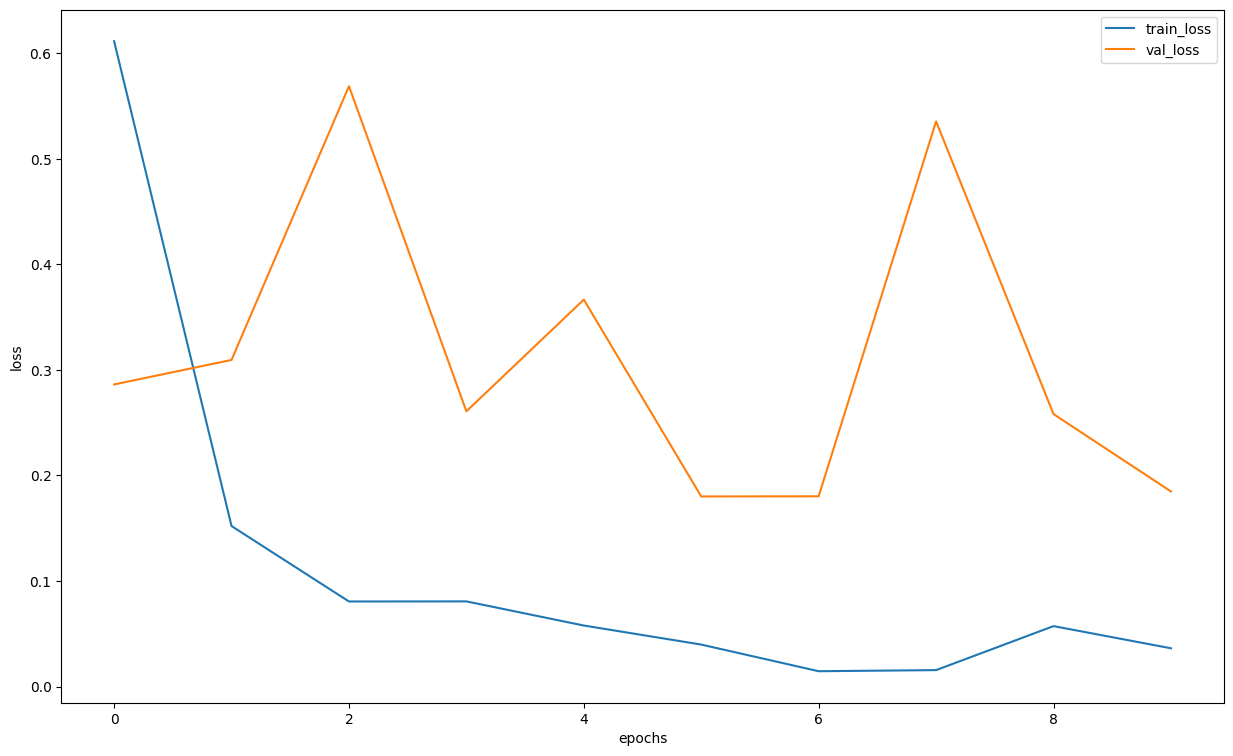

In [32]:
# Графики
loss, acc, val_loss, val_acc = zip(*history)

plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [34]:
import pandas as pd

df_history = pd.DataFrame(history, 
                         columns=['train_loss', 'train_acc', 'val_loss', 'val_acc'])

# Добавим номер эпохи
df_history['epoch'] = range(1, len(history)+1)

# Покажем всю таблицу
pd.set_option('display.max_rows', None)
print(df_history)

   train_loss  train_acc  val_loss                          val_acc  epoch
0    0.611525   0.855277  0.286263  tensor(0.9234, device='cuda:0')      1
1    0.152049   0.961908  0.309473  tensor(0.9217, device='cuda:0')      2
2    0.080570   0.979234  0.568935  tensor(0.8720, device='cuda:0')      3
3    0.080665   0.976878  0.260810  tensor(0.9383, device='cuda:0')      4
4    0.057789   0.984075  0.366646  tensor(0.9152, device='cuda:0')      5
5    0.039743   0.989872  0.180104  tensor(0.9578, device='cuda:0')      6
6    0.014486   0.995923  0.180255  tensor(0.9633, device='cuda:0')      7
7    0.015540   0.995541  0.535547  tensor(0.8922, device='cuda:0')      8
8    0.057233   0.984267  0.258183  tensor(0.9465, device='cuda:0')      9
9    0.036234   0.990827  0.184853  tensor(0.9589, device='cuda:0')     10


In [ ]:
# Вообще, есть небольшое переобучение(не критичное). 
# Вцелом, обучение довольно быстрое сразу с первой эпохи(и сразу лечше SimpleCNN из ноутбука с ДЗ). К седьмой эпохе получен лучший результат (val_acc=96.33%). 
# Довольно сильное падение val_acc я объясняю несбалансированностью классов(это я установил в ноутбуке с ДЗ, где игрался с аугментацией).

# Можно было бы и здесь поиграться с параметрами, с аугментацией и т.п., но боюсь не успею к дедлайну.

In [42]:


# Вывод содержимого
dataset_path = '/kaggle/input/journey-springfield-zip/'
contents = os.listdir(dataset_path)
print("Содержимое датасета:")
for item in contents:
    print(f"• {item}")

Содержимое датасета:
• sample_submission.csv
• testset
• characters_illustration.png
• train


In [40]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=128)
probs = predict(model, test_loader)

preds = val_dataset.label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [41]:
my_submit = pd.read_csv('/kaggle/input/journey-springfield-zip/sample_submission.csv')
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.to_csv('submisson.csv', index=False)
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
# Скор на кагле: Score: 0.97555

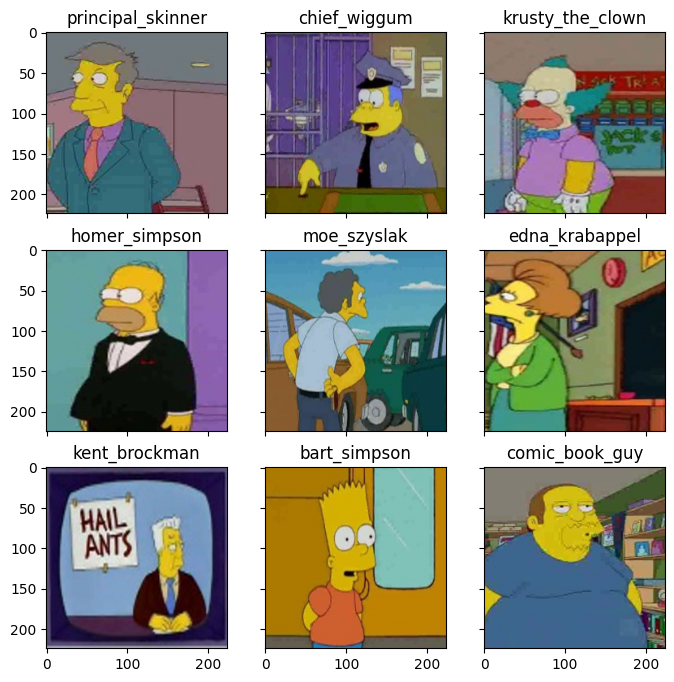

In [44]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,900))
    im_val, img_label = test_dataset[random_characters], preds[random_characters]
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [43]:
print(os.listdir('/kaggle/working/'))

['best_model.pth', 'submisson.csv', 'label_encoder.pkl', '.virtual_documents', 'state.db']
